In [1]:
import vit_prisma

from nltk.corpus import wordnet as wn
from datasets import load_dataset

from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import torch

import matplotlib.pyplot as plt

# nltk.download('wordnet')

import numpy as np
from fancy_einsum import einsum

from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT

from collections import defaultdict

import plotly.graph_objs as go
import numpy as np
import re  # Import the regular expressions library
import matplotlib.pyplot as plt
from PIL import Image


import plotly.graph_objs as go
import numpy as np

import re  # Import the regular expressions library



In [2]:


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])

def transform_batch(examples):
    images = [transform(image) for image in examples['image']]
    labels = torch.tensor(examples['label'])
    return {'image': images, 'label': labels}




In [3]:
# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
prisma_model = HookedViT.from_pretrained("vit_base_patch32_224", 
                                        center_writing_weights=True, 
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


In [6]:
# Load jpeg
image = Image.open("images/cubs.png")
image = transform(image).unsqueeze(0)

In [16]:
from vit_prisma.utils.imagenet.imagenet_emoji import IMAGENET_EMOJI

In [57]:

def get_patch_logit_directions(cache):
    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, return_labels=True
    )
    scaled_residual_stack = cache.apply_ln_to_stack(
        accumulated_residual, layer=-1,
    )
    all_answers = prisma_model.tokens_to_residual_directions(np.arange(1000))

    result = torch.einsum('lbpd,od -> lbpo', scaled_residual_stack, all_answers)
    # Rearrange so batches are first
    result = result.permute(1, 2, 0, 3)
    return result

def get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label=None):
    patch_dictionary = defaultdict(list)
    # Go through laeyrs of one batch
    patch_info = np.array((patch_logit_directions.shape[1], patch_logit_directions.shape[2])) # logit, class_name
    for patch_idx, patches in enumerate(patch_logit_directions[batch_idx]):
        # Go through every patch and get max prediction
        for logits in patches:        
            probs = torch.softmax(logits, dim=-1)
            # Get index of max prediction
            idx = int(torch.argmax(probs))
            logit = logits[idx].item()
            class_name = IMAGENET_DICT[idx]
            if rank_label:
                # Where is the rank_label in the sorted list?
                imagenet_index = imagenet_index_from_word(rank_label)
                sorted_list = torch.argsort(probs, descending=True)
                rank = np.where(sorted_list == imagenet_index)[0][0]
                patch_dictionary[patch_idx].append((logit, class_name, idx, rank))
            else:
                patch_dictionary[patch_idx].append((logit, class_name, idx))
    return patch_dictionary

def display_patch_logit_lens(patch_dictionary):

    # # Keywords to identify cat-related entries, prepared as a regex pattern for whole words
    # cat_keywords = ['cat', 'lynx', 'leopard', 'cougar', 'puma', 'lion', 'tiger', 'panther']
    # cat_pattern = r'\b(' + '|'.join(cat_keywords) + r')\b'

    # Assuming patch_dictionary is already defined and structured as before

    # Simulate patch_dictionary for demonstration
    # patch_dictionary = {i: [(np.random.random(), f'label_{j}') for j in range(25)] for i in range(50)}

    # Extracting numeric values for heatmap
    data_array_formatted = np.array([[item[0] for item in list(patch_dictionary.values())[i]] for i in range(50)])

    # Extracting labels for hover text
    hover_text = [[str(i) + " " + item[1] for item in list(patch_dictionary.values())[i]] for i in range(50)]

    # Creating the interactive heatmap
    fig = go.Figure(data=go.Heatmap(
        z=data_array_formatted,
        x=list(patch_dictionary.keys()),
        y=[f'Patch {i}' for i in range(data_array_formatted.shape[0])],
        hoverongaps=False,
        colorbar=dict(title='Values'),
        text=hover_text,
        hoverinfo="text"
    ))

    # Initialize a list to hold annotations
    annotations = []

    # Calculate half the distance between cells in both x and y directions
    x_half_dist = 0.5
    y_half_dist = 0.2

    for i, patch in enumerate(patch_dictionary.values()):
        for j, (_, _, class_index) in enumerate(patch):  # Extract class index directly from the patch_dictionary
            emoji = IMAGENET_EMOJI.get(class_index, "")  # Use class index for emoji lookup, default to empty if not found
            if emoji:  # Add annotation if emoji is found
                annotations.append(go.layout.Annotation(x=j + x_half_dist, y=i + y_half_dist, text=emoji, showarrow=False, font=dict(color="white", size=12)))

    # Add annotations to the figure
    fig.update_layout(annotations=annotations)

    # Add annotations to the figure
    fig.update_layout(annotations=annotations)

    fig.update_layout(
        title='Per-Patch Logit Lens',
        xaxis=dict(title='Layer Number'),
        yaxis=dict(title='Patch Number'),
        # autosize=False,
        width=1200,
        height=800
    )
    fig.show()



def residual_stack_to_logit_diff(
    residual_stack,
    cache,
    pos_slice
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=pos_slice
    )

    # # print shapes
    # print(scaled_residual_stack.shape)
    # print(answer_residual_directions.shape)

    result = torch.einsum('ijk,lk->ijl', scaled_residual_stack, all_answers)
    return result

def patch_logit_lens(cache):

    patch_ranks = np.empty((50, 25))
    patch_logits = np.empty((50, 25))
    patch_dictionary = defaultdict(list)

    for pos_slice in range(50):
        patch_info = []

        accumulated_residual, labels = cache.accumulated_resid(
            layer=-1, incl_mid=True, pos_slice=pos_slice, return_labels=True
        )

        predictions = residual_stack_to_logit_diff(accumulated_residual, cache, pos_slice=pos_slice)

        top_k = 5
        batch_idx = 1

        rank_list = []
        top_of_multiple = []
        for layer_idx, logits in enumerate(predictions[:,batch_idx,:]):

            probs = logits.softmax(dim=-1)
            probs = probs.squeeze(0).detach().numpy()
            sorted_probs = np.sort(probs)[::-1]
            sorted_probs_args = np.argsort(probs)[::-1]

            print("Layer", layer_idx)
            for i in range(top_k):
                index = sorted_probs_args[i]
                prob = sorted_probs[i]
                logit = logits[index].item()  # Assuming you want to show the original logit value
                label = IMAGENET_DICT[index]  # Adjust based on your mapping

                logit_str = f"Logit: {logit:.2f}"
                prob_str = f"Prob: {prob * 100:.2f}%"
                token_str = f"Label: |{label}|"

                # print(f"{rank_str} {logit_str} {prob_str} {token_str}")
                if i == 0:
                    patch_dictionary[pos_slice].append((logit, label))
            

            answer_index = imagenet_index_from_word("tabby cat")
            answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
            # print("Rank of the correct answer:")
            for ans_index in answer_indices:
                rank = np.where(sorted_probs_args == ans_index)[0][0]
                logit = logits[ans_index].item()
            
            print(f"Class Name: {'tabby cat'} | Rank: {rank} | ImageNet Index: {answer_index}")
            rank_list.append(rank)

            patch_ranks[pos_slice, layer_idx] = rank
    return patch_ranks




In [98]:

def imagenet_index_from_word(search_term):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        if search_term in value.lower():  # Convert each value to lowercase for case-insensitive comparison
            return key  # Return the key directly once found

    # If the loop completes without returning, the term was not found; raise an exception
    raise ValueError(f"'{search_term}' not found in IMAGENET_DICT.")

In [99]:
output, cache = prisma_model.run_with_cache(image)

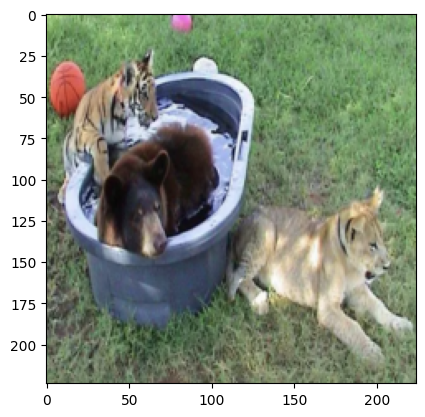

In [100]:
plt.figure()


plt.imshow(image[0].permute(1, 2, 0))

In [105]:
patch_logit_directions = get_patch_logit_directions(cache)
patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label=False)

display_patch_logit_lens(patch_dictionary)


In [142]:
display_grid_on_image_with_emojis(image[0], patch_dictionary=patch_dictionary, imagenet_class_to_emoji=IMAGENET_EMOJI)

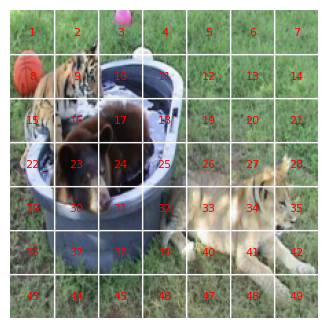

In [92]:

def display_grid_on_image(image, patch_size=32):

    if isinstance(image, torch.Tensor):
        image = image[0].detach().numpy().transpose(1,2,0)

    if image.shape[0] != 224:
        image = image.transpose(1,2,0)

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    num_patches = (image.shape[0] / patch_size) ** 2

    grid_size = int(np.sqrt(num_patches))

    # Calculate patch size
    patch_height = image.shape[0] // grid_size
    patch_width = image.shape[1] // grid_size

    # Overlay grida
    grid_image = np.copy(image)
    for i in range(1, grid_size):
        # Vertical lines
        grid_image[:, patch_width * i, :] = [255, 255, 255]
        # Horizontal lines
        grid_image[patch_height * i, :, :] = [255, 255, 255]

    plt.figure(figsize=(4, 4), dpi=100)  # Adjust figsize and dpi as needed

    # Place labels
    for i in range(grid_size):
        for j in range(grid_size):
            x_center = (j * patch_width) + (patch_width // 2)
            y_center = (i * patch_height) + (patch_height // 2)
            # Convert the patch index to 2D coordinates (row, column)
            patch_index = i * grid_size + j
            row, col = divmod(patch_index, grid_size)
            plt.text(x_center, y_center, f"{patch_index+1}", color='red', fontsize=8, ha='center', va='center')

    # Display image with grid and labels
    # plt.figure(figsize=(8, 8))
    plt.imshow(grid_image)
    plt.axis('off')
    plt.show()

    # return figure
    # return grid_image


display_grid_on_image(image)

In [93]:
image.shape

torch.Size([1, 3, 224, 224])

In [94]:
# load
image_animals = Image.open("images/many_animals.jpeg")

In [95]:
image_animals = transform(image_animals).unsqueeze(0)

In [96]:
output, cache = prisma_model.run_with_cache(image_animals)

In [97]:
patch_logit_directions = get_patch_logit_directions(cache)
patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label=False)

display_patch_logit_lens(patch_dictionary)


KeyboardInterrupt: 

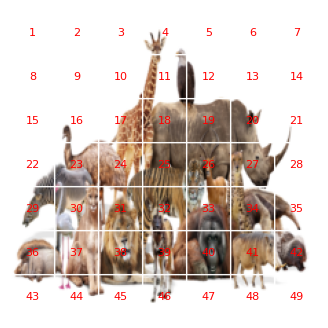

In [70]:
display_grid_on_image(image_animals)

In [140]:
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

def display_grid_on_image_with_emojis(image, patch_size=32, patch_dictionary=None, imagenet_class_to_emoji=None):
    """
    Display an image with a grid overlay and annotations for each patch using Plotly,
    where each patch is annotated with its corresponding emoji and index,
    skipping the CLS token and using the last logit of the patch data.
    A scatter plot overlay provides hover text with class names.

    Args:
    - image (numpy.ndarray or torch.Tensor): The image to display.
    - patch_size (int): The size of each patch, default is 32.
    - patch_dictionary (dict): A dictionary where keys are patch indices (skipping the CLS token) and values are lists of tuples (logit, class_name, class_index).
    - imagenet_class_to_emoji (dict): A dictionary mapping class indices to emojis.
    """
    if isinstance(image, np.ndarray) and image.shape[-1] == 3:
        pass  # Assuming image is in correct format
    elif isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy().transpose(1, 2, 0)
        if image.max() <= 1.0:
            image *= 255
        image = image.astype(np.uint8)

    grid_size = image.shape[0] // patch_size

    fig = px.imshow(image)
    fig.update_traces(hoverinfo='none', hovertemplate=None)

    x_centers = []
    y_centers = []
    texts = []
    hover_texts = []
    for patch_index, patch_data in sorted(patch_dictionary.items()):
        if patch_index == 0:  # Skip the CLS token
            continue
        
        # Use the last logit data instead of the max
        last_logit_data = patch_data[-1]
        _, class_name, class_index = last_logit_data
        
        # Adjust for the skipped CLS token by subtracting 1 from the index for positioning
        adjusted_index = patch_index - 1
        row, col = divmod(adjusted_index, grid_size)
        x_center = col * patch_size + patch_size / 2
        y_center = row * patch_size + patch_size / 2

        emoji = imagenet_class_to_emoji.get(class_index, "")
        annotation_text = f"{emoji}<br>{patch_index}"

        x_centers.append(x_center)
        y_centers.append(y_center)
        texts.append(annotation_text)
        hover_texts.append(class_name)

    # Overlay invisible markers for hover text
    fig.add_trace(go.Scatter(x=x_centers, y=y_centers, text=texts, mode='text', textposition="middle center",
                             hoverinfo='text', hovertext=hover_texts, textfont=dict(size=12)))

    fig.update_layout(showlegend=False)
    fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)

    fig.show()


In [141]:
display_grid_on_image_with_emojis(image_animals[0], patch_dictionary=patch_dictionary, imagenet_class_to_emoji=IMAGENET_EMOJI)

In [146]:
# load three animals
three_animals = Image.open("images/three_animals.png")
three_animals = transform(three_animals).unsqueeze(0)

In [147]:
output, cache = prisma_model.run_with_cache(three_animals)

In [148]:
patch_logit_directions = get_patch_logit_directions(cache)
patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label=False)


In [149]:
display_patch_logit_lens(patch_dictionary)
